%%latex
\tableofcontents 
\setcounter{section}{0}

# Review 
In the last notebook the semiconductor part of the SMOX grains was addressed. This included the numerical calculation the charge carrier density as as function of the conduction band bending. Additionally the Poisson equation for spherical grains was solved.
The grain results are saved to file and can now be here used again.
Additionally a Python module was created. In this module all the parts we need to recycle from the previous notebook are merged together.
By merging the relevant classes and functions into on python file, the command:
`from part2 import *`
will execute all the commands in this file and add them to the main namespace. By this the classes `material` and `grain` will again be available for further evaluations.


In [117]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'axes', 'vdot', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [118]:
from part2 import *


# Load the results

In [188]:
calc_dF = pd.read_hdf('results.h5', 'corr')
calc_dF.index = range(len(calc_dF))

In the following code block, we define a function, that will initialize a new `grain` object from the saved data from the previous notebook. All required data is given in the imported table. The helper function will initialize the `grain` with the corresponding `material` and return it.

In [189]:
def create_grain_from_data(dF):
    if type(dF)==pd.Series:
        dF = pd.DataFrame([dF])
        
    if len(dF['temp'].unique())==1:
        T_C = dF['temp'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['ND'].unique())==1:
        ND = dF['ND'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['mass_eff'].unique())==1:
        mass_e_eff_factor = dF['mass_eff'].unique()[0]/CONST.MASS_E 
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['R'].unique())==1:
        grainsize_radius = dF['R'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
        

    

    material = Material(T_C,ND)
    grain = Grain(grainsize_radius=grainsize_radius,material=material)
    
    return grain


With the helper function initializing a grain from a saved dataset, we can again represent the results from the previous notebook. Such a representation will be helpful for a better understanding of the needed steps to calculate the total resistance of a grain.

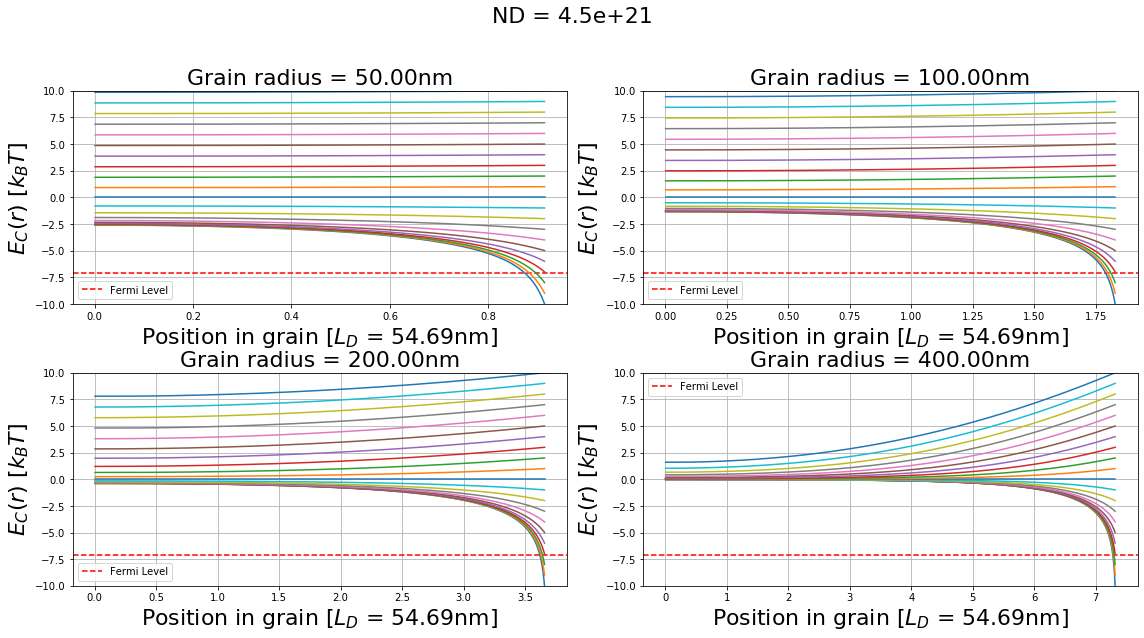

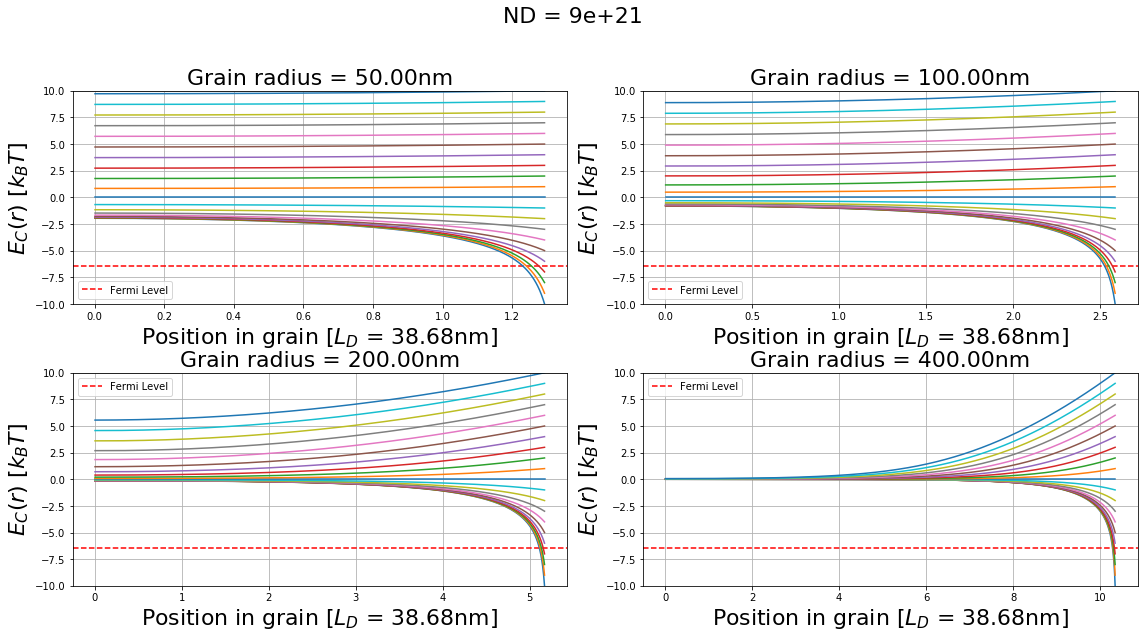

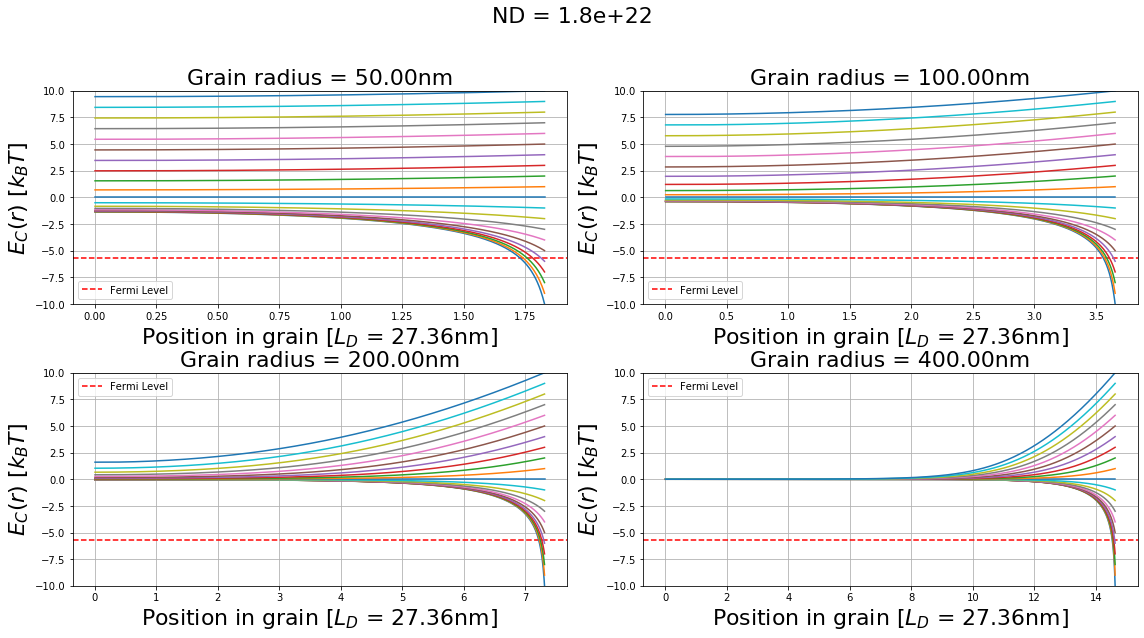

In [190]:
for ND, calc_dF_ND in calc_dF.groupby('ND'):
    fig, axes= subplots(2,2,figsize = (16,9))
    fig.suptitle(f'ND = {ND}', fontsize = 22)
    for ax_i, (R, calc_dF_grainsize) in enumerate(calc_dF_ND.groupby('R')):
        axe = fig.axes[ax_i]

        grain = create_grain_from_data(calc_dF_grainsize)


        axe.axhline(-grain.material.J_to_kT(grain.material.Diff_EF_EC),
                    linestyle='--',color='r', label='Fermi Level')
        axe.set_ylim(-10,10)

        for vinit, ser_temp in calc_dF_grainsize.iterrows():

            r = ser_temp['r']
            v = ser_temp['v']
            vdot = ser_temp['v_dot']

            axe.set_title(f'Grain radius = {grain.R*1e9:.2f}nm', fontsize=22)

            axe.plot(r,v, '-', label = "")
            axe.set_ylabel('$E_C(r)$ [$k_BT$]', fontsize =22)
            axe.set_xlabel(f'Position in grain [$L_D$ = {grain.material.LD*1e9:.2f}nm]',
                           fontsize =22)
        axe.legend()
        axe.grid(b=True)
    fig.tight_layout()
    fig.subplots_adjust(top=.85)


This graph shows how a surface potential is shielded by the remaining ionized donors. In the case of on deletion layer ( $E_{C_{Surface}}>0 )$), the total number of charges shielding the surface potential is rather small compared to the amount of charges in an accumulation layer ( $E_{C_{Surface}}<0 )$). The result of such an asymmetry is visible in the graph. The width of the accumulation layer is by far smaller then the width of the depleted are.

# From charge distribution to resistance

## The "numerical" grain



With the previous tools and calculation it is now possible to assign each point inside the grain a certain charge density. From the charge density the conductivity can be derived.
The conductivity of a semiconductor is defined by:
\begin{align}
 Conductivity  = \sigma = q*\left(n*\mu_n +p*\mu_p\right)
\end{align}
Here $q$ is the electrical charge of an electron, $n$ the density of electrons in the conduction band and $\mu_n$ the mobility of the electrons.
For the case of and p-type semiconductor like $SnO_2$ with $n>>p$, the conductivity can be simplified to the following equation:
\begin{align}
Conductivity  = \sigma = q*n*\mu_n 
\end{align}
The relation between resistivity $\rho$ and the conductivity is given by:
\begin{align}
R = \frac{{\rho}*l}{A}\\
Resistivity  = \rho = \frac{1}{\sigma}
\end{align}

To derive the from the known conductivity inside the grain, the total resistance of the grain, the current path needs to be known. The current flow along the field lines inside the grain, which are proportional to the gradient of the potential. Therefore the potential distribution inside the grain needs to be known. To do this, the grain is represented by a numerical model by slicing it into equal distributed cubes of the same size. Each cube will have a defined conductivity and potential. The colored areas in the picture indicate the areas, where a bias potential will be applied to generate a virtual electrical field.

![Numerical Grain](media/pics/sliced_cube.png)

To simulate the spread of the bias potential areas inside the grain, a technique called relaxation will be used. The general idea is to guess an initial potential distribution, and then, based on the laws of physics, iteratively correct this guess. The correction is done by re-calculating each time the potential $U_0$ of one center-"cube" based on potential $U_i$ and conductivity $\sigma$ of the direct neighbors. By doing this for each "cube", the potential distribution will more and more apply to the physical solution. When approaching to the solution, the overall changes in the potential of each cube will get smaller and smaller. In an ideal case it will not change anymore. In this case the potential of eachcube will be just as it should be to fulfill the laws of physics.
To understand how this process can be supported by the means of modern matrix operations, I will shorty derive how $U_0$ is calculated from the surrounding $U_i$. In a second step matrix convolution will be used to solve the problem efficiently.
First we will need to combine Ohm's law and Kirchhoff's first law:
\begin{align}
R  = \frac{\Delta U}{I} = \frac{{\rho}*l}{A} and \sum_{i}I_i=0\\
\rightarrow \sum_{i}\frac{\Delta U_i}{R_i} = \sum_{i}\frac{U_0-U_i}{\rho_i}\frac{A}{l}=0\\
\rightarrow \sum_{i}\frac{U_0-U_i}{\rho_i}\frac{A}{l}=0\\
\rightarrow \sum_{i}\frac{U_0}{\rho_i}=\sum_{i}\frac{U_i}{\rho_i}\\
\rightarrow U_0\sum_{i}\frac{1}{\rho_i}=\sum_{i}\frac{U_i}{\rho_i}\\
\rightarrow U_0=\frac{\sum_{i}\frac{U_i}{\rho_i}}{\sum_{i}\frac{1}{\rho_i}}\\
\rightarrow U_0=\frac{\sum_{i}{U_i*\sigma_i}}{\sum_{i}{\sigma_i}}=\frac{\sum_{i}{U_i*q*n*\mu_n }}{\sum_{i}{q*n*\mu_n }}\\=\frac{q*\mu_n}{q*\mu_n} \frac{\sum_{i}{U_i*n_i}}{\sum_{i}{n_i}}=\frac{\sum_{i}{U_i*n_i}}{\sum_{i}{n_i}}\label{u_center}\tag{$U_0$ from $U_i$}\\
\end{align}
With $A$ the cube face area and $l$ the distance between the cube centers, which have no relevance when using a model where all cubes are equal.

To evaluate the each $n_i$ at arbitrary points r inside the grain, one additional step is needed. Due to the nature of the numerical solution from the previous notebook we know the value of $n$ only at specific points. For values between those fix-points, an interpolation between the neighbors can be used. Again, SciPy and Python offer here also a easy to use and robust solution.
`from scipy import interpolate` adds the `interpolate` module into the kernel. The `interp1d` function of this module is described ([here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.htm)) as follows:
>Interpolate a 1-D function.
>
>x and y are arrays of values used to approximate some function f: y = f(x). This class returns a function whose call method uses interpolation to find the value of new points.

Since the values of $n$ and $r$ exist already precalculated for specific points in the Dataframe, the following function is used to create the appropriate function for continuous values of r.

In [191]:
from scipy import interpolate

def get_interpolated_n_v(ser,grain):
    
    v = ser['v']
    r = ser['r']
    n = ser['n']
    
    r[0] = 0
    
    n_int = interpolate.interp1d(r*grain.material.LD, n, kind='linear')
    v_int = interpolate.interp1d(r*grain.material.LD, v, kind='linear')
    
    return n_int, v_int

As mentioned earlier, the positions of the applied potential will only be the cubes on the far left and right, as indicated in the picture. By arranging the bias voltage like this, the potential inside the grain will have a rotational symmetry along the axis connecting the two poles. The benefit of the resulting symmetry by using this simplification is to be able to represent the potential inside the grain by a $N\times N$ Matrix, where $N$ are the number of cubes inside the grain. Since $N\times N$ data structures are very common in modern application fields like computer vision and image recognition, many algorithm dealing with such data structures are available.
First we create now the data structure of the grain for further simulations. The $N\times N$ cubes will be represented by a `numpy` array. 

In [192]:
def pos_to_r_o(xi,yi,grain, d):
    '''
    By passing the xi and yi indices, the grain and one array, the position (r)
    inside the grain is return
    '''
    dx = 2*grain.R/d.shape[0]
    cx = d.shape[0]//2
    cy = d.shape[1]//2
    ri = ((xi-cx)**2+(yi-cy)**2)**0.5
    return(ri*dx)





def initaliz_d_v(d_v, d_mask, v):
    d_v[:,1] = -v
    d_v[:,0] = -v
    d_v[:,-2] = +v
    d_v[:,-1] = +v
    d_v = d_v*d_mask
    return d_v



def pos_to_r(xi,yi,grain, cube_size, d):
    '''
    By passing the xi and yi indices, the grain and one array, the position (r)
    inside the grain is return
    '''
    
    
    cx = d.shape[0]//2+1-1 #find the center; length divided by two without rest; +1; -1 since we start at 0
    cy = d.shape[1]//2+1-1
    
    ri = (((xi-cx))**2+((yi-cy))**2)**0.5
    if False:
        rx = -grain.R+xi*cube_size#+0.5*cube_size
        ry = -grain.R+yi*cube_size#+0.5*cube_size
    
        r = (rx**2+ry**2)**0.5
    else:
        r = (ri*cube_size)
    return r

def r_to_pos(r, grain, cube_size, d_v):
    center = d_v.shape[0]//2
    return int(round(r/cube_size))+center
    

def create_numerical_grain_matrix( grain, ser,cube_size):
    #these functions are needed to calculate the value of n and
    #v at arbitrary positions
    n_int, v_int = get_interpolated_n_v(ser, grain)
    nx = ny = 1+2*int(round((grain.R/cube_size)))
    #print(nx,ny)

    #initalize the data for the volatege (d_v) and conductivity (d_cond) with zeros
    d_v = np.zeros((nx,ny))
    d_cond = np.zeros((nx,ny))
    
    #an additional mask for values outside the grain will be created
    d_mask = np.zeros((nx,ny))
    

    for xi in range(d_cond.shape[0]):
        for yi in range(d_cond.shape[1]):
            r = float(pos_to_r(xi,yi,grain, cube_size, d_v))
            try:
                #if r is outside the grain, n_int(r) will fail and got the except part below
                # otherwise the conductivity will be saved in units of nb
                
                condu = n_int(r)/grain.material.nb
                
                d_cond[xi, yi] = condu
                
                #since this point is inside the grain, the mask is 1
                d_mask[xi,yi] = 1

            except ValueError:
                #outside the grain
                d_cond[xi, yi] = 0
                d_mask[xi,yi] = 0
    d_v = initaliz_d_v(d_v, d_mask, 1000)
    return d_v, d_cond, d_mask

## Precalc the numerical grains for all conditions
The grain data structure can now a represented graphically. For faster interactive response, we will pre initialize all the grains for the data available.
Due to the similarity of the $N\times N$ data structure to common pictures, the function `imshow` is very handy to represent the data.


In [193]:
d_cond_plots = []
for i, ser in calc_dF.iterrows():
    print(f'Initalized {i+1} of {len(calc_dF)}.', end='\r', flush=True)
    grain = create_grain_from_data(ser)
    d_v, d_cond,d_mask = create_numerical_grain_matrix( grain, ser,cube_size=5e-9)
    d_cond_plot = d_cond.copy()
    d_cond_plot[np.where(d_mask==0)]=None
    d_cond_plots.append(d_cond_plot)
calc_dF.loc[:, 'd_cond'] = d_cond_plots

KeyboardInterrupt: 

In [127]:
calc_dF.to_hdf('precalc_dF.h5','raw', mode= 'w')

/usr/lib/python3.8/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['n', 'r', 'v', 'v_dot', 'd_cond']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [128]:
calc_dF = pd.read_hdf('precalc_dF.h5','raw')

In [194]:
%matplotlib inline

In [195]:

def plot_grain_states(calc_dF_grainsize, vmax=None, vmin=None):
    fig, axes = subplots(3,3, figsize = (16,9))
    
    grain = create_grain_from_data(calc_dF_grainsize)

    for ax_i, (vinit, ser) in enumerate(calc_dF_grainsize.iterrows()):
        axe = fig.axes[ax_i]
        
        Einit_kT = ser['Einit_kT']

        axe.set_title(r'$E_{C_{Surface}}=$'+f'{Einit_kT}kT')
        axe.set_ylabel('x [nm]')
        axe.set_xlabel('y [nm]')
        
        d_cond_plot = calc_dF.loc[ser.name, 'd_cond']
        #using axe.imshow to plot the data on the axe
        axe.grid(b=True, zorder=-5)
        im = axe.imshow(np.log(d_cond_plot), interpolation='bicubic',
                        extent=(-grain.R*1e9, grain.R*1e9, -grain.R*1e9, grain.R*1e9),
                        vmax=vmax, vmin=vmin, cmap='hot', zorder=2)
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    ND = calc_dF_grainsize['ND'].unique()[0]
    fig.suptitle(f'ND: {ND}', fontsize=22)
    


def plot_conductivity(GrainRadius, ND=9e21):
    R = GrainRadius/1e9
    calc_dF_grainsize = calc_dF.groupby(['ND','R']).get_group((ND,R))
    max_n = np.log(calc_dF_grainsize['d_cond'].apply(lambda r:np.nanmax(r))).max()
    min_n = np.log(calc_dF_grainsize['d_cond'].apply(lambda r:np.nanmin(r))).min()
    
    plot_grain_states(calc_dF_grainsize, vmax = max_n, vmin = min_n)


use_interactive_controls = True

if use_interactive_controls:
    from ipywidgets import interact, interactive, fixed, interact_manual
    import ipywidgets as widgets
    grainsizes = list(calc_dF['R'].unique())
    interact(plot_conductivity, GrainRadius=np.array(grainsizes)*1e9,ND=list(calc_dF.groupby(['ND']).groups.keys()), text='Select a grainsize:');
else:
    GrainRadius = 200
    
    for ND in list(calc_dF.groupby(['ND']).groups.keys()):
        plot_conductivity(GrainRadius, ND)
        

interactive(children=(Dropdown(description='GrainRadius', options=(50.0, 100.0, 200.0, 400.0), value=50.0), Dr…

## Relaxation
### Concolute2d:
Equation ($\ref{u_center}$) is the basis of the relaxation process. The potential at each cube will be recalculated according to:
$U_0 = \frac{\sum_{i}{U_i*n_i}}{\sum_{i}{n_i}}\label{u_center}$. The indices $i$ stand for the direct neighbors of $U_0$.
The following simple example should explain how `convolve2d` can be used to solve our task. The function needs two parameters as inputs. The first is the matrix itself, while the second is the description of the convolution operation. 
In a very short description, this is What the algorithm will do:

1. goto on datapoint i_x_y
2. multiply the neighbors of i_x_y with the corresponding value of the second argument
3. sum up the results and save it a the position of the datapoint i_x_y
4. do this for all data points

It would be out of the scope to dig deeper into the details of convolutions, but this working a bit with the following example should reveal the main concept.


In [196]:
from scipy import signal

U = np.array([[1,2,3],[1,2,3],[1,2,3]])
print('U:')
print(U)
print()

n = np.array([[1,1,1],[10,10,10],[100,100,100]])
print('n:')
print(n)
print()

print('U*n')
print(U*n)
print()

conv = np.array([[0,1,0],[1,0,1],[0,1,0]])
print('Conv')
print(conv)
print()


signal.convolve2d(U*n, conv, boundary='fill', mode='same', fillvalue=0)

U:
[[1 2 3]
 [1 2 3]
 [1 2 3]]

n:
[[  1   1   1]
 [ 10  10  10]
 [100 100 100]]

U*n
[[  1   2   3]
 [ 10  20  30]
 [100 200 300]]

Conv
[[0 1 0]
 [1 0 1]
 [0 1 0]]



array([[ 12,  24,  32],
       [121, 242, 323],
       [210, 420, 230]])

In the example it can be shown, how this function is helpful for solving the relaxation problem. For instance the sum over the direct neighbors of the center is: $10+2+30+200=242$, This is exact the value as return by the function.
The process of calculating the convoluted matrix is done for the nominator and the denominator. After the division $U_0$ is obtained.
Some additional steps as masking the potentials outside the grain setting the bias again.
If the potential down not change anymore, the iterations can be stopped.

In [197]:
from scipy import signal


def solve_relaxation(d_v, d_cond, d_mask, n = 10000000):
    res_new = 1000
    #shortly disable the error when dividing by zero (denominator)
    old_settings = np.seterr()
    np.seterr(divide='ignore', invalid='ignore')
    conv = [[0,1,0],[1,0,1],[0,1,0]]
    denominator = signal.convolve2d(d_cond, conv, boundary='fill',
                                mode='same', fillvalue=0)
    for i in range(n):

        
        numerator = signal.convolve2d(d_v*d_cond, conv, boundary='fill',
                                      mode='same', fillvalue=0)

        d_v_new = (numerator/denominator)*d_mask
        d_v_new = np.nan_to_num(d_v_new,0)

        d_v_prev = d_v.copy()
        

        
        d_v = d_v_new.copy()
        d_v = initaliz_d_v(d_v, d_mask, 1000)

        res_pre = res_new
        res_new = np.abs(np.sum(d_v_prev-d_v))

        if i%10000==1:
            #print(res_pre,res_new)
            
            if ((res_pre - res_new)==0) and (i>40000):
                break
    #setting back the defaults
    np.seterr(**old_settings)
    return d_v, d_cond, d_mask


When the potentials inside the grain is solved with the relaxation algorithm, it is time to calculate the total resistance of the grain. Since the relaxation was solved by applying a "virtual" potential ($\Phi$) to the grain, the total resistance $\Omega$ could be calculated by Ohm's low: $\Omega = \frac{\Delta \Phi}{Current}$, where $\Delta \Phi = V$ is the potential difference.

Therefore only the current trough the grain needs to be calculated. This can be done by calculating the total current passing the slice in the center of the grain. 
\begin{align}
j=\underset{A\rightarrow0}{lim}\frac{I_{A}}{A}=\underset{d\rightarrow0}{lim}\frac{I_{A}}{d*d}=\sigma E \\
E = \frac{V}{d}=\frac{\Delta \Phi}{d} \\
I_A = \sigma*V*d
\end{align}
which will be the current going through one cube

In [198]:
def calc_current_center(d_v, d_cond, d_mask, cube_size, grain):
    #center_pos = d_v.shape[0]//2
    #center_pos = 20
    center_pos = r_to_pos(0, grain, cube_size, d_v)
    center_current = (d_v[:,center_pos+1]-d_v[:,center_pos-1])*d_cond[:,center_pos]
    
    r = np.array([float(pos_to_r(xi,center_pos,grain, cube_size, d_v)) for xi in range(len(center_current))])
    
    center_current_tot = np.sum(center_current*2*pi*r)
    return center_current_tot, center_current, r

In [199]:
calc_dF['current'] = None

# See how a single solution evolves
The interactive environment of Jupyter will be needed here. The following command activates it. (For some unknown reasons, you might need to execute this command 2-3 times to get activated)

In [200]:
%matplotlib inline

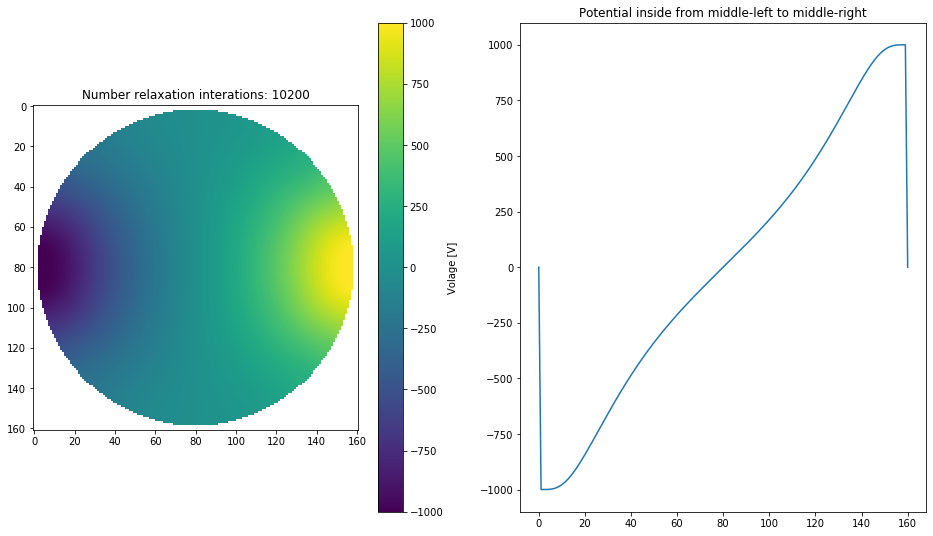

In [18]:
import matplotlib.animation as animation

c_dF = calc_dF.copy()
cube_size = 5e-9
c_dF['cube_size'] = cube_size
ser =c_dF[(c_dF['R']==400e-9) & (c_dF['Einit_kT']==-8) & (c_dF['ND']==9e21)].iloc[0]

vinit = ser.name
grain = create_grain_from_data(ser)

if cube_size=='LD':
    cube_size_value = grain.material.LD/2
else:
    cube_size_value = cube_size

d_v, d_cond, d_mask = create_numerical_grain_matrix( grain, ser,cube_size=cube_size_value)
ns = 0
def update(frame):
    axe.clear()
    axe_v.clear()
    n = 100
    global d_v
    global ns
    ns+=n
    axe.set_title(f'Number relaxation interations: {ns}')
    axe_v.set_title('Potential inside from middle-left to middle-right')
    
    d_v, _, _ = solve_relaxation(d_v = d_v , d_cond=d_cond, d_mask=d_mask, n=n)
    d_v_plot = d_v.copy()
    d_v_plot[np.where(d_mask==0)]=None
    img = axe.imshow(d_v_plot,interpolation='bicubic',)
    
    
    axe_v.plot(d_v[r_to_pos(0,grain, cube_size, d_v),:])
    
    #plot_grad(axe_g, axe_c, d_v=d_v, d_mask=d_mask)
    
    return img


fig, axes = subplots(1,2, figsize = (16,9))
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

axe = axes[0]

img = axe.imshow(d_v)
cb = colorbar(img, ax = axe)
cb.ax.set_ylabel('Volage [V]')

axe_v = axes[1]


ani = FuncAnimation(fig, update, frames = list(range(100)), interval=10,blit=False, repeat = False)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('im.mp4', writer=writer)

plt.show()

And also save the animation as a video. Save this animation 

The video can then be loaded again and played back in the notebook.

In [19]:
from IPython.display import Video
display(Video('./im.mp4'))


### Precalcualtion of all conditions

In [308]:
def calc_conv_by_ser(ser):
    cube_size = ser['cube_size']
    vinit = ser.name

    grain = create_grain_from_data(ser)
    if cube_size=='LD':
        cube_size_value = grain.material.LD/3
    else:
        cube_size_value = cube_size

    d_v, d_cond, d_mask = create_numerical_grain_matrix( grain, ser,cube_size=cube_size_value)
    d_v = initaliz_d_v(d_v, d_mask, 1000)
    solve_relaxation(d_v, d_cond, d_mask, n = 10000000)
    d_v, d_cond, d_mask = solve_relaxation(d_v, d_cond, d_mask)

    center_current_tot, center_current, r = calc_current_center(d_v, d_cond, d_mask, cube_size_value, grain)
    #print(center_current_tot)
    #plot_num_grain(d_v, d_cond, d_mask)
    #plot_voltage_1d(d_v)
    #plot_center_current(r, center_current)
    ser_out = ser.copy()
    ser_out.loc['current'] = center_current_tot
    ser_out['d_v'] = d_v
    ser_out['d_mask'] = d_mask
    ser_out['cube_size_value']=cube_size_value
    return ser_out

In [202]:
from multiprocessing import Pool
#for vinit, ser in calc_dF.iterrows():
all_solutions = []
for cube_size in ['LD']:
    c_dF = calc_dF.copy()
    c_dF['cube_size'] = cube_size
    if False:
        for i, ser in c_dF.iterrows():
            print(ser)
            all_solutions.append(calc_conv_by_ser(ser))
            print('Done')
            print()
    else:
        ser_list = []
        for i, ser in c_dF.iterrows():
            ser_list.append(ser)
        with Pool(12) as p:
            all_res_list = p.map(calc_conv_by_ser, ser_list)
        calc_dF_sol = pd.DataFrame(all_res_list)

In [307]:
calc_dF_sol.to_hdf('numerical_sol.h5','raw', mode='w',complevel=9,complib='bzip2')

In [214]:
import pickle
with open('originaks.pk', 'wb') as f:
    pickle.dump(calc_dF_sol, f)

In [215]:
import pickle
with open('originaks.pk', 'rb') as f:
    calc_dF_sol = pickle.load(f)

In [216]:
grain.material.nb-grain.material.n(0)[0]


0.0

# check the integral for the charges

In [217]:
ser = calc_dF_sol.iloc[6]
ser = cd2[(calc_dF_sol['R']==100e-9) & (calc_dF_sol['ND']==1.8e+22) & (calc_dF_sol['Einit_kT']==4)].iloc[0]
grain = create_grain_from_data(ser)
all_c = 4.0/3.0*pi*(ser['R']**3)*grain.material.n(0)[0]
print(all_c)
grain.R/grain.material.LD
[grain.material.n(v)[0] for v in ser['v']]
print(np.trapz(np.array(ser['n'])*4*pi*(ser['r']*grain.material.LD)**2, ser['r']*grain.material.LD))
calc_sum_of_charges(ser)

150.59124497328185
7.348213263249368


EPSILON                                                                  9.86
E_dor_init_kT                                                         1.15877
Einit_kT                                                                    4
ND                                                                    1.8e+22
R                                                                       1e-07
mass_eff                                                          2.73282e-31
n                           [4.997331759418244e+21, 4.997331759418244e+21,...
nb                                                                 3.5951e+22
r                           [0.0, 0.007309830966079894, 0.0109647464491198...
res                                                                   0.11315
temp                                                                      300
v                           [1.9742581082397077, 1.9742581082397077, 1.974...
v_dot                       [0.0031371875181921373, 0.0031371875

In [218]:
def calc_sum_of_charges(ser):
    ser = ser.copy()
    grain = create_grain_from_data(ser)
    cs = []
    for r_i, r in enumerate(ser['r'][0:-1]):
        uV = (ser['r'][r_i+1]*grain.material.LD)**3*4/3*pi
        lV = (ser['r'][r_i]*grain.material.LD)**3*4/3*pi
        cs.append((uV-lV)*ser['n'][r_i])
    surf_c = np.sum(cs)
    
    all_c = 4.0/3.0*pi*(ser['R']**3)*grain.material.n(0)[0]
    
    ser['all_charges'] = all_c
    ser['surf_charges'] = surf_c
    return ser

In [219]:
cd2 = calc_dF_sol.apply(calc_sum_of_charges, axis=1)

In [250]:
%matplotlib inline

2.2437598599589404e+23
1.9321471344333845e+23
1.4159292658094375e+23
5.141135653433602e+22


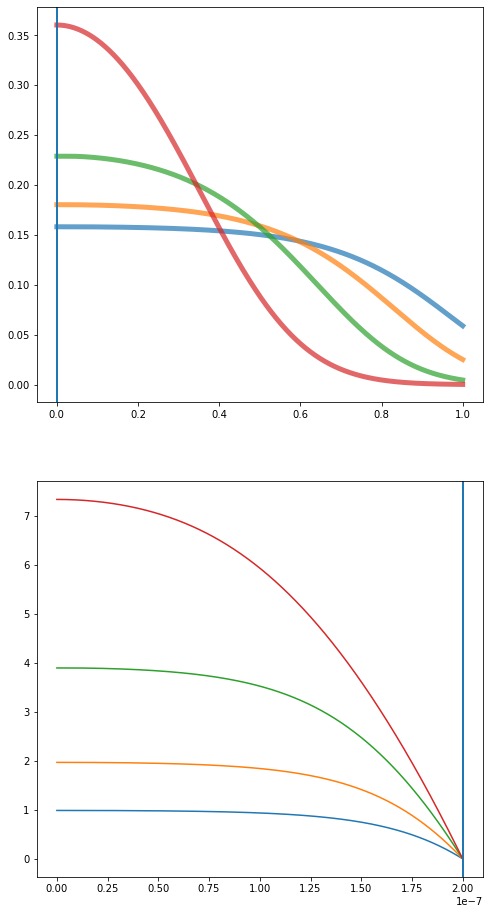

In [302]:
index = 8
ser = calc_dF_sol.iloc[index]


fig, axes = subplots(2, figsize=(8,16))
for v in [1,2,4,8]:
    ser = cd2[(calc_dF_sol['R']==200e-9) & (calc_dF_sol['ND']==1.8e+22) & (calc_dF_sol['Einit_kT']==v)].iloc[0]
    grain = create_grain_from_data(ser)


    #print(alle,surf, round((surf-alle)/alle*100,2))

    axe = axes[0]
    #axe.set_yscale('log')
    n_avg = np.trapz(ser['n'], ser['r'])
    #n_avg = ser['all_charges']
    print(n_avg)
    axe.plot(ser['r']*grain.material.LD/ser['R'], np.array(ser['n'])/n_avg, linewidth=5, alpha=0.7)
    #axe.axhline(grain.material.n(0)[0], c='k', linestyle='--')
    axe.axvline(ser['R'])
    
    axe = axes[1]
    axe.plot(ser['r']*grain.material.LD, v-np.array(ser['v']))
    #axe.set_ylim(-8,8)
    axe.axvline(ser['R'])
    ser

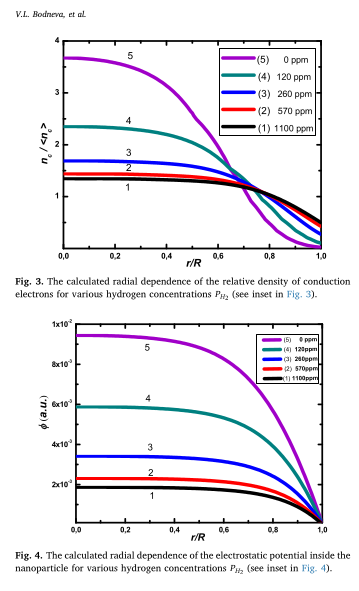
Example from:

[related publication](./Papers/Modeling_of_sensor_properties_for_reducing_gases_and_charge_distribution_in.pdf)

### Comparing with experimental data

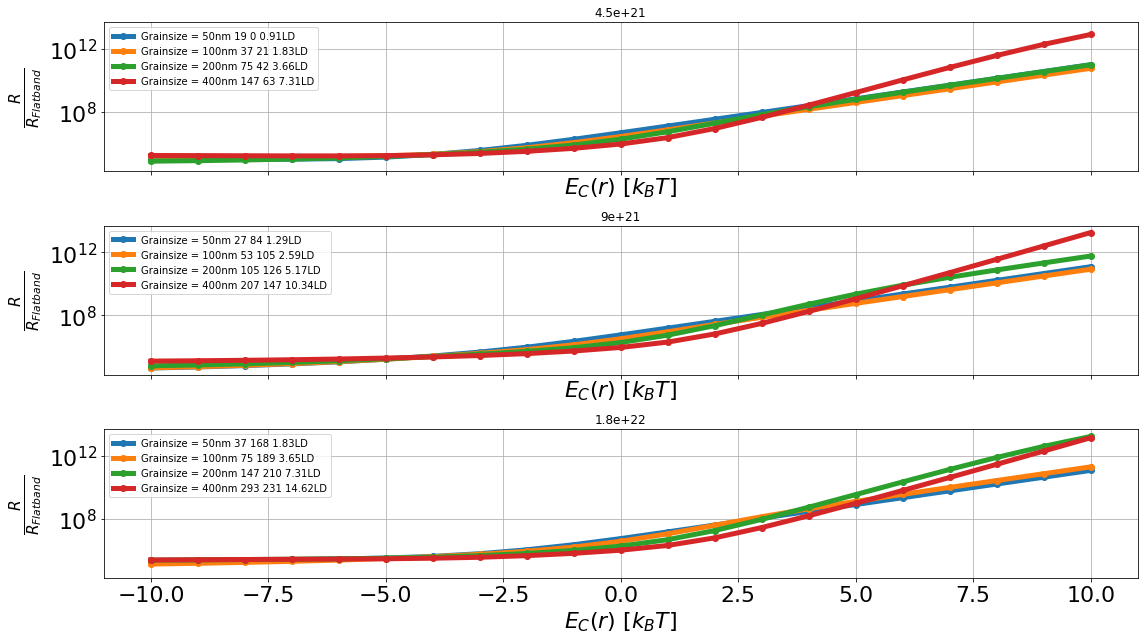

In [221]:
calc_dF_size = calc_dF_sol
calc_dF_size = cd2
fig, axes = subplots(len(calc_dF_size['ND'].unique()),1,figsize = (16,9), sharey=True, sharex=True)
if len(fig.axes)==1:
    axes = [axes]
for ax_i,(size_n,calc_dF_n) in enumerate(calc_dF_size.groupby('ND')):
    
    axe = axes[ax_i]
    axe.set_title(size_n)
    for ax_i, (R,calc_dF_grainsize) in enumerate(calc_dF_n.groupby('R')):
        
        grain = create_grain_from_data(calc_dF_grainsize.iloc[0])
        #print((grain.material.LD)*1e9)
        #print(calc_dF_grainsize['d_v'].iloc[0].shape)
        s = calc_dF_grainsize['d_v'].iloc[0].shape[0]
        #print(calc_dF_grainsize['cube_size_value'].iloc[0]*1e9)
        #print()
        
        flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['current']
        res = flat_band/calc_dF_grainsize['current']
        res = 2000/calc_dF_grainsize['current']
        
        
        #res = 1/calc_dF_grainsize['current']
        v = calc_dF_grainsize['Einit_kT']
        rel_size = grain.R/grain.material.LD
        axe.plot(v, res, 'o-', label = f'Grainsize = {R*1e9:.0f}nm {s} {calc_dF_grainsize.iloc[0].name} {rel_size:.2f}LD', linewidth=5)
        
        
        axe.set_yscale('log')
        
        axe.set_ylabel(r'$\frac{R}{R_{Flatband}}$', fontsize =22)
        axe.set_xlabel('$E_C(r)$ [$k_BT$]', fontsize =22)
        
        axe.tick_params(axis='both', which='major', labelsize=22)
        
        axe.grid(b=True)

    fig.tight_layout()
    axe.legend()



In [246]:
%matplotlib qt5

In [247]:
calc_dF_size = calc_dF_sol
calc_dF_size = cd2
#fig, axes = subplots(len(calc_dF_size['ND'].unique()),1,figsize = (16,9), sharey=True, sharex=True)
if len(fig.axes)==1:
    axes = [axes]
fig, axe = subplots(1,1,figsize = (16,9), sharey=True, sharex=True)
for ax_i,(size_n,calc_dF_n) in enumerate(calc_dF_size.groupby('ND')):
    
    #axe = axes[ax_i]
    axe.set_title(size_n)
    axe2= axe.twinx()
    for ax_i, (R,calc_dF_grainsize) in enumerate(calc_dF_n.groupby('R')):
        
        grain = create_grain_from_data(calc_dF_grainsize.iloc[0])
        #print((grain.material.LD)*1e9)
        #print(calc_dF_grainsize['d_v'].iloc[0].shape)
        s = calc_dF_grainsize['d_v'].iloc[0].shape[0]
        #print(calc_dF_grainsize['cube_size_value'].iloc[0]*1e9)
        #print()
        
        flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['current']
        res = flat_band/calc_dF_grainsize['current']
        #res = 2000/calc_dF_grainsize['current']
        sc = calc_dF_grainsize['all_charges']-calc_dF_grainsize['surf_charges']
        #print(sc,(grain.material.LD**(2/3)*surf))
        surf = R**2*4*pi
        #surf_ratio = (grain.material.nb**(2/3)*surf)/sc
        surf_ratio = abs(sc/surf)
        
        sc = calc_dF_grainsize['all_charges']
        
        #res = 1/calc_dF_grainsize['current']
        v = calc_dF_grainsize['Einit_kT']
        rel_size = grain.R/grain.material.LD
        #axe.plot(v, res, 'o-', label = f'Grainsize = {R*1e9:.0f}nm {s} {calc_dF_grainsize.iloc[0].name} {rel_size:.2f}LD', linewidth=5)
        axe.plot(surf_ratio, res, 'o-', label = f'Grainsize = {R*1e9:.0f}nm {s} {calc_dF_grainsize.iloc[0].name} {rel_size:.2f}LD', linewidth=5)
        idxmax = res.idxmax()
        axe.text(surf_ratio.loc[idxmax], res.loc[idxmax]*random.randint(50,200)/100, f'{rel_size:.2f}LD {R*1e9:.0f}nm')
        #axe2.plot(v,surf_ratio,  'o-', linewidth=1,label = f'Grainsize = {R*1e9:.0f}nm {s} {calc_dF_grainsize.iloc[0].name} {rel_size:.2f}LD')
        
        
        axe.set_yscale('log')
        axe2.set_yscale('log')
        axe.set_xscale('log')
        axe.set_xlim(1e14,1e17)
        axe.set_ylabel(r'$\frac{R}{R_{Flatband}}$', fontsize =22)
        axe.set_xlabel('$E_C(r)$ [$k_BT$]', fontsize =22)
        
        axe.tick_params(axis='both', which='major', labelsize=22)
        
        axe.grid(b=True)
        axe2.legend()

    fig.tight_layout()
    axe.legend()


    
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


### The 'm' factor

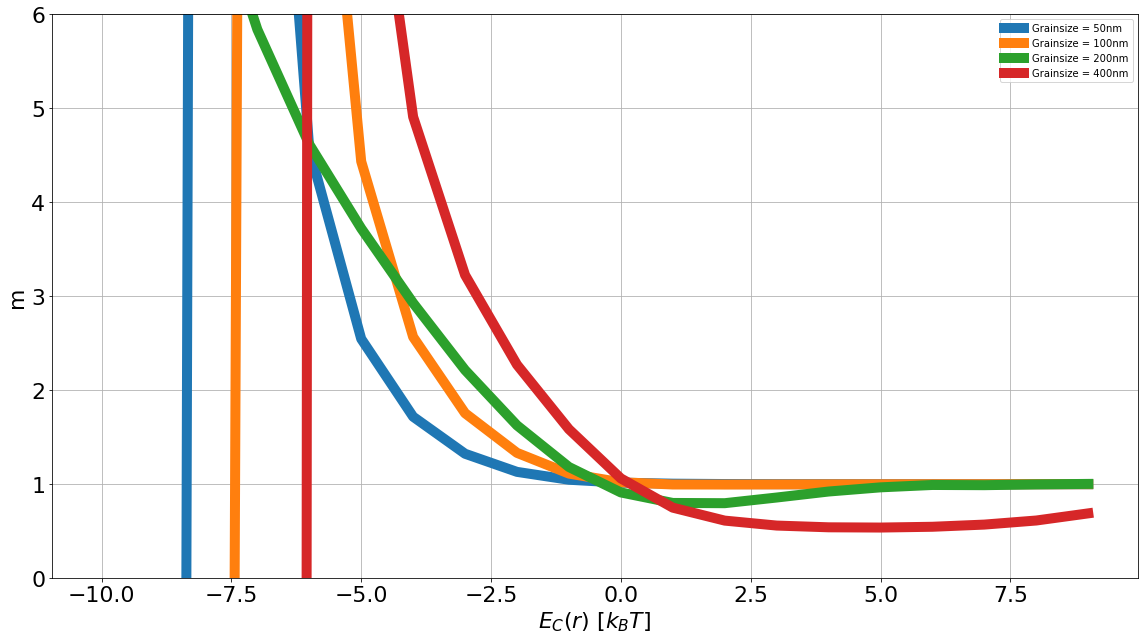

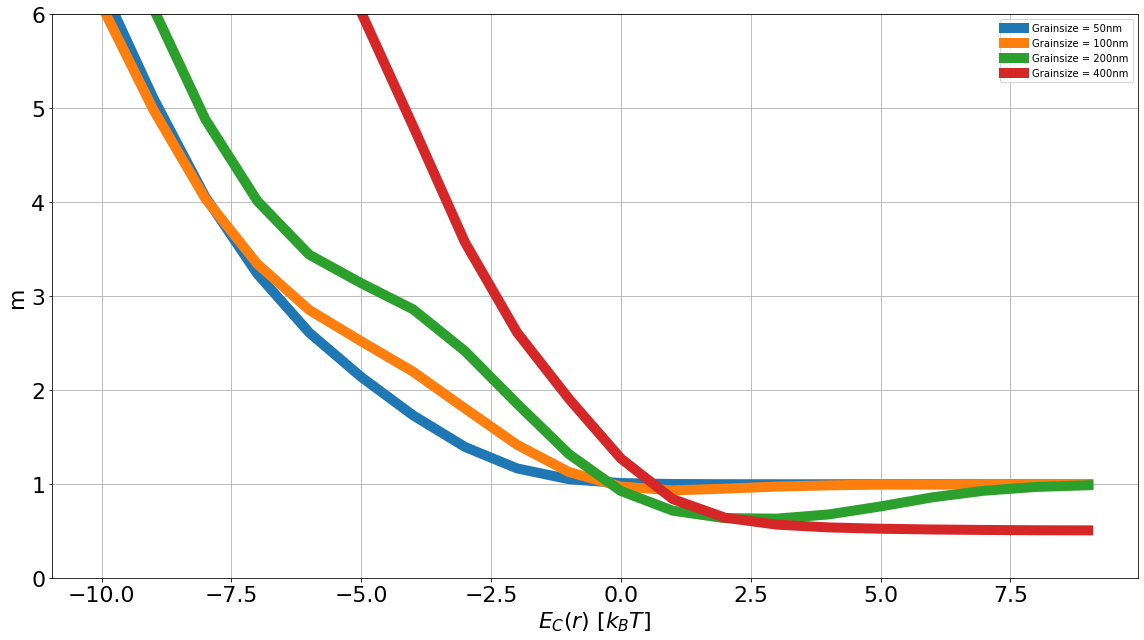

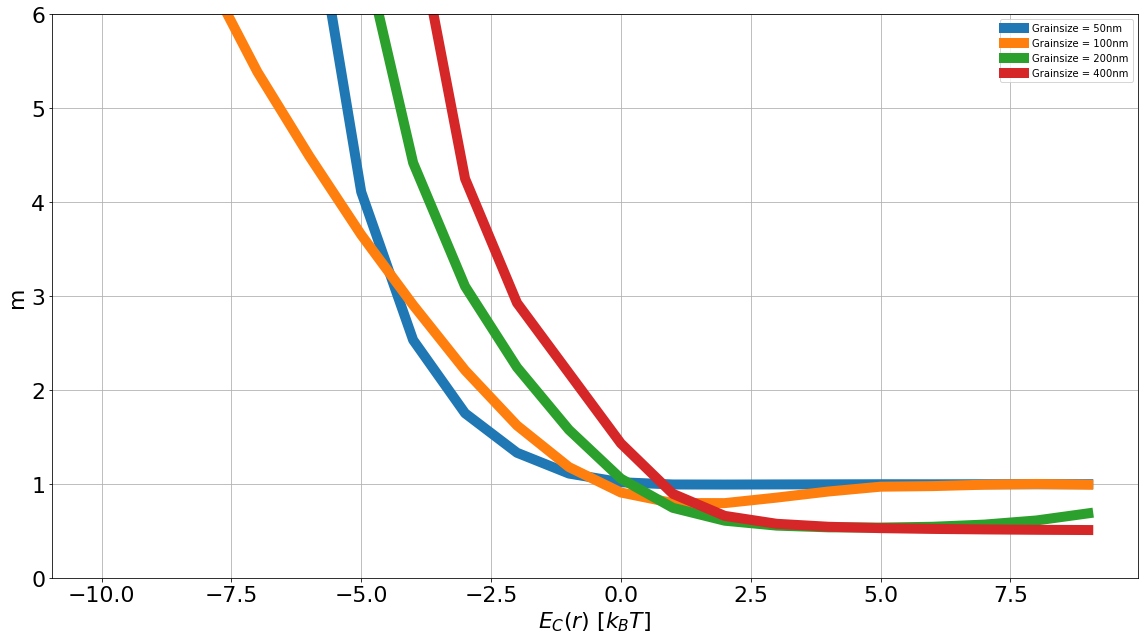

In [223]:

size_n = 1e-8
calc_dF_n_all_ND = cd2
    
for ND,calc_dF_n in calc_dF_n_all_ND.groupby('ND'):

    fig, axe = subplots(1,1,figsize = (16,9), sharey=True, sharex=True)
    for ax_i, (R,calc_dF_grainsize) in enumerate(calc_dF_n.groupby('R')):


        flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['current']
        res = flat_band/calc_dF_grainsize['current']
        res = 1/calc_dF_grainsize['current']
        log_res = np.log([float(r) for r in res.values])
        m = np.diff(log_res)/np.diff(v)
        
        sc = calc_dF_grainsize['surf_charges']
        #print(sc,(grain.material.LD**(2/3)*surf))
        surf = R**2*4*pi
        #surf_ratio = (grain.material.nb**(2/3)*surf)/sc
        surf_ratio = sc/surf
        v = calc_dF_grainsize['Einit_kT']
        axe.plot(v[0:-1], 1/m,'o-', label = f'Grainsize = {R*1e9:.0f}nm', linewidth=10)
        #axe.plot(v, res, 'o-', label = f'{size_n} {R}', linewidth=5)
        #axe.set_yscale('log')

        axe.tick_params(axis='both', which='major', labelsize=22)

        axe.set_ylabel('m', fontsize  = 22)
        axe.set_xlabel('$E_C(r)$ [$k_BT$]', fontsize =22)
        axe.grid(b=True)
        axe.set_ylim(0,6)

    fig.tight_layout()
    axe.legend();


In [ ]:

def plot_num_grain(d_v, d_cond, d_mask):
    fig, axes =subplots(1,3)
    d_v_plot = d_v.copy()
    d_v_plot[np.where(d_mask==0)]=None

    axes[0].imshow(d_mask)
    axes[1].imshow(d_cond)
    axes[2].imshow(d_v_plot,interpolation= 'nearest')
    
def plot_voltage_1d(d_v):
    fig, axe = subplots()
    center = d_v[d_v.shape[0]//2,:]
    axe.plot(center)

def calc_current_center(d_v, d_cond, d_mask):
    center_pos = d_v.shape[0]//2
    center_current = (d_v[:,center_pos+1]-d_v[:,center_pos-1])*d_cond[:,center_pos]
    
    r = np.array([float(pos_to_r(xi,center_pos,grain, d_v)) for xi in range(len(center_current))])
    
    center_current_tot = np.sum(center_current*r*2*pi)
    return center_current_tot, center_current, r

def plot_center_current(r, center_current):
    fig, axe = subplots()
    axe.plot(r*1e9,center_current)
    return

#vinit, current = calc_current(d_v, d_cond, d_mask)

In [ ]:
for i, ser in calc_dF.iterrows():
    print(f'Initalized {i+1} of {len(calc_dF)}.', end='\r')
    grain = create_grain_from_data(ser)
    d_v, d_cond,d_mask = create_numerical_grain_matrix( grain, ser,size_n=100)
    d_cond_plot = d_cond.copy()
    d_cond_plot[np.where(d_mask==0)]=None
    calc_dF.loc[ser.name, 'd_cond'] = [d_cond_plot]

In [ ]:
calc_dF.to_hdf('res.h5', 'raw')

# Bibliography section

%%latex
\bibliographystyle{alphadin}
\bibliography{ipython}